*   Multimídia - Compressão JPEG (Exercício 2)

*   Felipe Daniel Dias dos Santos - 11711ECP004

*   Graduação em Engenharia de Computação - Faculdade de Engenharia Elétrica - Universidade Federal de Uberlândia

In [ ]:
#Função para converter o sistema de BGR para RGB (simples troca de ordem) de uma imagem "im"
def bgr2rgb(im):

  #Definição da imagem resultante
  im_RGB = np.empty(im.shape, np.uint8)

  #Troca de ordem dos canais para gerar uma imagem RGB
  im_RGB[:, :, 0] = im[:, :, 2]
  im_RGB[:, :, 1] = im[:, :, 1]
  im_RGB[:, :, 2] = im[:, :, 0]

  return im_RGB

In [ ]:
#Função para subamostragem dos canais de crominância Cr e Cb de uma imagem "im"
def subSample(im):

  #Utilização de filtros do tipo "box" para uma redução de 2 vezes em ambas as dimensões das matrizes de crominância
  Cr = cv2.boxFilter(im[:, :, 1], ddepth=-1, ksize=(2, 2))
  Cb = cv2.boxFilter(im[:, :, 2], ddepth=-1, ksize=(2, 2))

  Cr_Sub = Cr[::2, ::2]
  Cb_Sub = Cb[::2, ::2]

  #Construção da imagem com as matrizes de crominância subamostradas e a matriz de luminância inalterada
  im_Sub = [im[:, :, 0], Cr_Sub, Cb_Sub]

  return im_Sub

In [ ]:
#Função para super-amostragem dos canais de crominância "Cr" e "Cb", tendo como parâmetro as dimensões do canal de luminância "Y"
def superSample(Cr, Cb, Y):

  #Obtenção das dimensões de Y
  n_rows, n_columns = Y.shape

  #Utilização da função "resize" para aumentar em 2 vezes as dimensões das matrizes de crominância
  Cr_Sup = cv2.resize(Cr, (n_columns, n_rows))
  Cb_Sup = cv2.resize(Cb, (n_columns, n_rows))

  return Cr_Sup, Cb_Sup

In [ ]:
#Função para separar uma imagem "im" em matrizes menores de 8x8
def getBlock(im):

  #Dimensões da imagem
  n_rows, n_columns = im.shape

  #Lista para armazenamento das sub-matrizes
  im_Set = []

  #Laço para percorrer toda a imagem e construir a lista
  for i in range(0, n_rows, 8):

    for j in range(0, n_columns, 8):

      #Cada elemento da matriz será normalizado com a subtração de 128 de seu valor
      elem = im[i : i + 8, j : j + 8] - 128.0

      im_Set.append(elem)

  return im_Set

In [ ]:
#Função para realizar a junção de todas as matrizes 8x8 armazenadas em um conjunto de matrizes "im_Set", dado como parâmetro as dimensões da imagem original
def join(im_Set, im):

  #Dimensões da imagem original
  n_rows, n_columns = im.shape

  #Matriz resultante
  im_F = np.zeros([n_rows, n_columns])

  #Variável de controle para realizar iteração no conjunto de matrizes
  k = 0

  #Laço para construção da matriz final
  for i in range(0, n_rows, 8):

    for j in range(0, n_columns, 8):

      #Obtenção da matriz corrente realizando uma soma de 128 unidades em todos os elementos
      elem = im_Set[k] + 128
      
      im_F[i : i + 8, j : j + 8] = elem

      k += 1

  return im_F

In [ ]:
#Função para o cálculo da transformada discreta de cosseno de um conjunto de matrizes 8x8 "im_Set"
def dct(im_Set):

  #Lista resultante
  im_Trans = []

  #Laço para realizar o cálculo em todas as matrizes da lista
  for i in range(len(im_Set)):

    #O cálculo é realizado com arredondamento
    elem = np.round(cv2.dct(im_Set[i]))

    im_Trans.append(elem)
  
  return im_Trans

In [ ]:
#Função para o cálculo da transformada discreta de cosseno inversa de um conjunto de matrizes 8x8 "im_Set"
def idct(im_Set):

  #Lista resultante
  im_ITrans = []

  #Laço para realizar o cálculo em todas as matrizes da lista
  for i in range(len(im_Set)):

    #O cálculo é realizado com arredondamento
    elem = np.round(cv2.idct(im_Set[i]))

    im_ITrans.append(elem)
  
  return im_ITrans

In [ ]:
#Função para quantização de uma lista de matrizes "im_Set"
def quant(im_Set):
  
  #Matriz de quantização
  Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])
  
  return np.round(im_Set / Q)

In [ ]:
#Função para de-quantização de uma lista de matrizes "im_Set"
def dquant(im_Set):

  #Matriz de quantização
  Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
               [12, 12, 14, 19, 26, 48, 60, 55],
               [14, 13, 16, 24, 40, 57, 69, 56],
               [14, 17, 22, 29, 51, 87, 80, 62],
               [18, 22, 37, 56, 68, 109, 103, 77],
               [24, 35, 55, 64, 81, 104, 113, 92],
               [49, 64, 78, 87, 103, 121, 120, 101],
               [72, 92, 95, 98, 112, 100, 103, 99]])
  
  return im_Set * Q

In [ ]:
#Função para operação de zig-zag ordenado de uma matriz 8x8, resultando em um vetor
def zigZag(im):

  #Matriz de zig-zag 
  Z = [0, 1, 8, 16, 9, 2, 3, 10,
	    17, 24, 32, 25, 18, 11, 4, 5,
	    12, 19, 26, 33, 40, 48, 41, 34,
	    27, 20, 13, 6, 7, 14, 21, 28,
	    35, 42, 49, 56, 57, 50, 43, 36,
	    29, 22, 15, 23, 30, 37, 44, 51,
	    58, 59, 52, 45, 38, 31, 39, 46,
	    53, 60, 61, 54, 47, 55, 62, 63]

  #Vetor resultante
  V_Z = []

  #Laço para percorrer a matriz de zig-zag
  for i in range(64):

    #Elemento corrente da matriz de zig-zag
    elem = Z[i]

    #Cálculo da posição da matriz  
    column = elem % 8 
    row = int(elem / 8)
    
    V_Z.append(im[row, column])
    
  return V_Z

In [ ]:
#Função para converter um vetor "V" em uma matriz, de forma a realizar a operação inversa ao zig-zag ordenado
def invZigZag(V):

  #Matriz de zig-zag 
  Z = [0, 1, 8, 16, 9, 2, 3, 10,
	    17, 24, 32, 25, 18, 11, 4, 5,
	    12, 19, 26, 33, 40, 48, 41, 34,
	    27, 20, 13, 6, 7, 14, 21, 28,
	    35, 42, 49, 56, 57, 50, 43, 36,
	    29, 22, 15, 23, 30, 37, 44, 51,
	    58, 59, 52, 45, 38, 31, 39, 46,
	    53, 60, 61, 54, 47, 55, 62, 63]
  
  #Matriz resultante
  im = np.empty([8, 8])

  #Laço para percorrer a matriz de zig-zag
  for i in range(64):

    #Elemento corrente da matriz de zig-zag
    elem = Z[i]

    column = elem % 8 
    row = int(elem / 8)
    
    #Cálculo da posição da matriz  
    im[row, column] = V[i]

  return im

In [ ]:
#Função para substituir a maior sequência de zeros de um vetor "V" e substituir pelo símbolo "0", isto é, eliminar a sequência redundante de zeros
def delZero(V):

  #Contagem do índice do vetor
  count = len(V) - 1

  #Variável de controle
  flag = 0

  #O vetor é analisado de trás para frente e a análise é finalizada assim que um valor distinto de zero for encontrado
  while flag == 0:

    if V[count] == 0:

      count -= 1

      if count <= 0:

        return [V[0]]
  
    else:

      flag += 1
      
  #Retornar o vetor sem a sequência final de zeros, devido a sua redundância
  return V[0 : count + 2] 

In [ ]:
#Função para complementar um vetor "V" com valores 0
def includeZero(V):

  #O vetor é incrementado até possuir 64 elementos
  while len(V) < 64:

    V.append(0)
      
  return V 

In [ ]:
#Função para converter um vetor "V" de valores inteiros em símbolos 
def int2simb(V):

  #Lista para armazenamento dos novos símbolos
  V_Simb = []

  #Laço para percorrer todo o vetor e realizar as substituições
  for i in range(len(V)):

    #Elemento normalizado para não assumir valores negativos
    elem = int(V[i] + 70)
    
    #COnversão de inteiro para caractere de acordo com a tabela ASCII
    V_Simb.append(chr(elem))

  return V_Simb

In [ ]:
#Função para converter um vetor "V" de símbolos em valores inteiros
def simb2int(V):

  #Lista para armazenamento dos novos valores inteiros
  V_Int = []

  for i in range(len(V)):

    #Obtenção do valor do elemento corrente
    elem = ord(V[i]) - 70

    V_Int.append(elem)

  return V_Int

In [ ]:
#Função para ordenação de um vetor de símbolos "alf" em ordem decrescente de acordo com suas frequências "freq"
def order(alf, freq):

  #Listas que serão armazenados os resultados referentes a "V" em ordem decrescente
  alf_ord = []
  freq_ord = []

  for i in range(len(alf)):

    #Índice do elemento de máxima frequência
    max = np.argmax(freq)

    #Obtenção do elemento do alfabeto de maior frequência para ser inserido no vetor de alfabeto ordenado
    alf_ord.append(alf[max])
    
    #Obtenção da maior frequência para ser inserido no vetor de frequência ordenada
    freq_ord.append(freq[max])

    #Eliminação do elemento já analisado
    freq[max] = -1

  return alf_ord, freq_ord

In [ ]:
#Função para o cálculo da tabela de códigos de acordo com o algoritmo de Huffman 
def huffman(alf_abs, alf_var, freq, cod):

  #Ordenação do alfabeto corrente e do vetor de frequências em ordem decrescente
  alf_var, freq = order(alf_var, freq)

  #Obtenção das dimensões dos vetores ordenados
  n_simb = len(alf_var)
  n_freq = len(freq)

  #Laço para análise do elemento de menor frequência do vetor do alfabeto corrente
  for i in range(len(alf_var[n_simb - 1])):
    
    #Obtenção do elemento corrente, presente no vetor "alf_var"
    elem = alf_var[n_simb - 1][i]

    #Obtenção da posição do elemento corrente no vetor "alf_abs"
    pos = alf_abs.index(elem)

    #Incrementação do código do elemento corrente, presente no vetor "cod", na posição espeficicada anteriormente 
    cod[pos] = '1' + cod[pos]
  
  #Laço para análise do segundo elemento de menor frequência do vetor do alfabeto corrente
  for i in range(len(alf_var[n_simb - 2])):
    
    #Obtenção do elemento corrente, presente no vetor "alf_var"
    elem = alf_var[n_simb - 2][i]

    #Obtenção da posição do elemento corrente no vetor "alf_abs"
    pos = alf_abs.index(elem)

    #Incrementação do código do elemento corrente, presente no vetor "cod", na posição espeficicada anteriormente 
    cod[pos] = '0' + cod[pos]

  #Se o vetor "alf_var" possuir mais de dois elementos, o algoritmo faz modificações em "alf_var" e "freq" e prossegue na execução do algoritmo
  if n_simb > 2:
  
    #Junção das duas menores frequências e atribuição na penúltima posição de "freq"
    freq[n_freq - 2] = freq[n_freq - 2] + freq[n_freq - 1]

    #Claramente, como atribuímos as duas útimas frequências na penúltima posição, devemos deletar a última posição
    freq = np.delete(freq, n_freq - 1)

    #Assim como no vetor "freq", devemos unir os dois últimos caracteres do vetor "alf_var", formando um novo símbolo para o alfabeto modificado
    alf_var[n_simb - 2] = alf_var[n_simb - 2] + alf_var[n_simb - 1]

    #E, novamente, deletar a última posição
    alf_var = np.delete(alf_var, n_simb - 1)

    #Recursão do algoritmo com os vetores "alf_var" e "freq" modificados e "alf_abs" e "cod" não modificados
    huffman(alf_abs, alf_var, freq, cod)

In [ ]:
#Função para codificação de um conjunto de dados "string", dado sua lista de códigos "cod" e seu alfabeto "alf"
def getCode(string, alf, cod):

  #String para armazenamento do resultado
  cod_string = ""

  for i in range(len(string)):

    #Obtenção do elemento corrente da string
    elem = string[i]
    
    #Obtenção da posição do elemento corrente no alfabeto
    pos = alf.index(elem)

    #Obtenção do código correspondente ao elemento corrente e junção do mesmo à codificação final
    cod_string += cod[pos]

  return cod_string

In [ ]:
#Função que recebe um conjunto de vetores "V_Set" e obtem as variáveis necessárias para a codificação de huffman, retornando a tabela de códigos, a tabela do alfabeto e o código final de cada vetor
def encoder(V_Set):

  #Listas para armazenamento dos resultados
  V_Alf = []
  V_Cod = []
  V_Final = []

  for i in range(len(V_Set)):

    #Obtenção das frequências e alfabeto do vetor "V"
    alf, freq = np.unique(V_Set[i], return_counts = True)

    #Conversão em listas
    alf = list(alf)
    freq = list(freq)

    #Variável para tabela de códigos
    cod = [""] * len(alf)

    #Codificação de Huffman
    huffman(alf, alf, freq, cod)

    #Obtenção da codificação final
    final = getCode(V_Set[i], alf, cod)

    V_Alf.append(alf)
    V_Cod.append(cod)
    V_Final.append(final)

  return V_Alf, V_Cod, V_Final

In [ ]:
#Função para decodificar um sequência de bits "seq", de acordo com uma tabela de códigos "cod" e um alfabeto "alf" que foi codificada pelo algoritmo de Huffman
def huffmanDecode(alf, cod, seq):

  #Variável para armazenamento do resultado
  decode = []

  #Variável para buffer
  buffer = ""

  #Laço para percorrer toda a sequência de bits
  for i in range(len(seq)):

    #Captura o bit corrente e verifica se está contido na tabela de códigos
    #Se não estiver, captura o próximo bit e anexa ao variável buffer
    buffer += seq[i]

    #Se estiver, trata o código detectado pelo buffer
    if buffer in cod:

      #Obtenção da posição do código detectado
      pos = cod.index(buffer)

      #Obtenção do símbolo do alfabeto na posição do código detectado
      elem = alf[pos]

      #Anexa o símbolo obtido ao resultado final
      decode.append(elem)

      #Limpa o buffer
      buffer = ""

  return decode

In [ ]:
#Função para realizar o cálculo do Mean Square Error (MSE) entre duas imagens "im_1" e "im_2"
def mse(im_1, im_2):

  mse = np.sum((im_1.astype("float") - im_2.astype("float")) ** 2)
  
  mse /= float(im_1.shape[0] * im_1.shape[1])

  return mse

In [ ]:
#Função para realizar o cálculo do Signal Noise Ratio (SNR) entre duas imagens "im_1" e "im_2"
def snr(im_1, im_2):

  sse = np.sum((im_1 - im_2) ** 2)

  snr = np.log10(sse / mse(im_1, im_2))

  return 10 * snr

In [ ]:
#Função para realizar o cálculo do Peak Signal Noise Ratio (PSNR) entre duas imagens "im_1" e "im_2"
def psnr(im_1, im_2):

  arg = (np.max(im_1)) ** 2

  psnr = np.log10(arg / mse(im_1, im_2))

  return 10 * psnr

In [ ]:
#Declaração das bibliotecas necessárias, definição do diretório raíz e montagem do diretório
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/Colab Notebooks/dados/'

Mounted at /content/gdrive


Definida a série de funções acima, será selecionada 1 imagem colorida para:

Comprimir a imagem;

Descomprimir a imagem;

Analisar o erro entre a imagem inicial (anterior à compressão) e final (posterior ao processo de descompressão).

Imagem original:


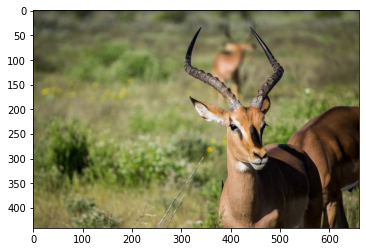

In [ ]:
#Etapa de compressão: Aquisição da imagem

#Obtenção da imagem original
im = cv2.imread(root_path + 'h1.jpg')

#Conversão do sistema BGR para RGB (troca de ordem)
im_Inicial = bgr2rgb(im)

#Exibir imagem original (RGB)
print("Imagem original:")
plt.imshow(im_Inicial)

Imagem original no espaço YCrCb:


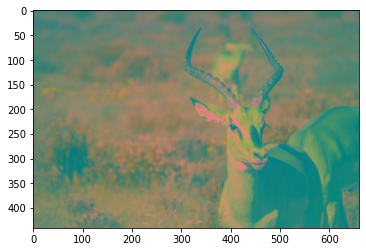

In [ ]:
#Etapa de compressão: Transformação do espaço de cores

#Conversão do sistema de cores RGB para YCrCb
im_YCrCb = cv2.cvtColor(im_Inicial, cv2.COLOR_RGB2YCR_CB)

#Exibir imagem após conversão (YCrCb)
print("Imagem original no espaço YCrCb:")
plt.imshow(im_YCrCb)

Canal Cr após subamostragem:


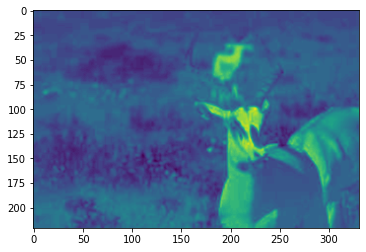

In [ ]:
#Etapa de compressão: Subamostragem dos canais de crominância

#Realização da subamostragem dos canais Cr e Cb
im_Sub = subSample(im_YCrCb)

#Exemplo: exibir o canal Cr  
#O canal Cr agora se encontra com a metade da quantidade de linhas e colunas em relação a imagem original
print("Canal Cr após subamostragem:")
plt.imshow(im_Sub[1])

In [ ]:
#Etapa de compressão: Separação dos canais em blocos 8x8

#Obtenção das dimensões dos canais Y e Cr
Y_rows, Y_columns = im_Sub[0].shape
Cr_rows, Cr_columns = im_Sub[1].shape

#Cortar imagem para que suas dimensões sejam múltiplas de 8, para facilitar o processo de divisão da imagem em blocos de 8x8
#Nesse caso, os canais podem perder alguns pixels
im_Sub[0] = im_Sub[0][0 : (Y_rows - Y_rows % 8), 0 : (Y_columns - Y_columns % 8)]
im_Sub[1] = im_Sub[1][0 : (Cr_rows - Cr_rows % 8), 0 : (Cr_columns - Cr_columns % 8)]
im_Sub[2] = im_Sub[2][0 : (Cr_rows - Cr_rows % 8), 0 : (Cr_columns - Cr_columns % 8)]

#Separação dos canais Y, Cr e Cb em grupos de matrizes 8x8
Y_Set = getBlock(im_Sub[0])
Cr_Set = getBlock(im_Sub[1])
Cb_Set = getBlock(im_Sub[2])

#Exemplo: exibir matriz qualquer da lista do canal de luminância 
#O canal Y agora se encontra separado, com suas partes dentro de uma lista, onde cada elemento é uma matriz 8x8
print("Matriz número 1001 do canal Y após o processo de separação:")
print(Y_Set[1000])

Matriz número 1001 do canal Y após o processo de separação:
[[-18. -19. -21. -22. -24. -26. -29. -30.]
 [-18. -19. -20. -22. -23. -25. -28. -30.]
 [-18. -19. -20. -21. -22. -24. -27. -29.]
 [-18. -18. -19. -19. -21. -23. -25. -27.]
 [-17. -17. -18. -18. -18. -20. -23. -25.]
 [-16. -16. -16. -16. -16. -18. -21. -23.]
 [-15. -15. -15. -14. -14. -16. -19. -21.]
 [-15. -15. -14. -13. -13. -15. -18. -20.]]


In [ ]:
#Etapa de compressão: Transformação discreta de cosseno

#Cálculo da transformada discreta de cosseno de cada matriz 8x8 de cada canal
Y_Trans = dct(Y_Set)
Cr_Trans = dct(Cr_Set)
Cb_Trans = dct(Cb_Set)

#Exemplo: exibir matriz qualquer da lista do canal de luminância após transformação
#O canal Y agora é uma lista, onde cada elemento é uma matriz 8x8 resultante do cálculo de transformação da lista anterior 
print("Matriz número 1001 do canal Y após o processo de transformação:")
print(Y_Trans[1000])

Matriz número 1001 do canal Y após o processo de transformação:
[[-159.   22.   -8.    4.    0.   -0.   -0.   -0.]
 [ -24.    8.    3.   -0.   -0.    0.    0.   -0.]
 [   3.    0.   -0.   -0.    0.   -0.    0.    0.]
 [   0.    0.    0.    0.    0.   -0.   -0.   -0.]
 [  -0.   -0.    0.   -0.    0.    0.   -0.   -0.]
 [  -0.    0.    0.   -0.    0.    0.   -0.   -0.]
 [  -0.   -0.   -0.   -0.    0.   -0.    0.    0.]
 [   0.   -0.    0.    1.    0.   -0.    0.   -0.]]


In [ ]:
#Etapa de compressão: Quantização

#Quantização dos três canais
Y_Quant = quant(Y_Trans)
Cr_Quant = quant(Cr_Trans)
Cb_Quant = quant(Cb_Trans)

#Exemplo: exibir matriz qualquer da lista do canal de luminância após quantização
#O canal Y agora está quantizado 
print("Matriz número 1001 do canal Y após o processo de quantização:")
print(Y_Quant[1000])

Matriz número 1001 do canal Y após o processo de quantização:
[[-10.   2.  -1.   0.   0.  -0.  -0.  -0.]
 [ -2.   1.   0.  -0.  -0.   0.   0.  -0.]
 [  0.   0.  -0.  -0.   0.  -0.   0.   0.]
 [  0.   0.   0.   0.   0.  -0.  -0.  -0.]
 [ -0.  -0.   0.  -0.   0.   0.  -0.  -0.]
 [ -0.   0.   0.  -0.   0.   0.  -0.  -0.]
 [ -0.  -0.  -0.  -0.   0.  -0.   0.   0.]
 [  0.  -0.   0.   0.   0.  -0.   0.  -0.]]


In [ ]:
#Etapa de compressão: Operação de Zig-Zag Ordenado

#Listas para armazenamento dos vetores resultantes (cada matriz de cada canal será convertida em vetor)
Y_Z = []
Cr_Z = []
Cb_Z = []

#Realizar a operação em todas as matrizes dos canais Y, Cr e Cb
for i in range(len(Y_Quant)):

  Y_Z.append(zigZag(Y_Quant[i]))

  #Análise dos canais Cr e Cb
  if i < len(Cr_Quant):
    
    Cr_Z.append(zigZag(Cr_Quant[i]))
    Cb_Z.append(zigZag(Cb_Quant[i]))

#Exemplo: exibir vetor qualquer da lista do canal de luminância após operação de zig-zag
#O canal Y, após o processo de zig-zag, passou de uma lista de matrizes para uma lista de vetores 
print("Vetor número 1001 do canal Y após o processo de zig-zag ordenado:")
print(Y_Z[1000])

Vetor número 1001 do canal Y após o processo de zig-zag ordenado:
[-10.0, 2.0, -2.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0]


In [ ]:
#Etapa de compressão: Eliminação da maior sequência de zeros (similar ao RLE)

#Listas para armazenamento dos vetores resultantes
Y_RLE = []
Cr_RLE = []
Cb_RLE = []

#Realizar a operação em todos os vetores dos canais Y, Cr, Cb
for i in range(len(Y_Z)):

  Y_RLE.append(delZero(Y_Z[i]))
  
  #Análise dos canais Cr e Cb
  if i < len(Cr_Z):

    Cr_RLE.append(delZero(Cr_Z[i]))
    Cb_RLE.append(delZero(Cb_Z[i]))

#Exemplo: exibir vetor qualquer da lista do canal de luminância após operação de eliminação de zeros redundantes
#O canal Y, após o processo, reduziu o tamanho de seus vetores de maneira significativa (inclusive, para vetores somente com valores 0, reduziu seu tamanho de 64 para 1)
print("Vetor número 1001 do canal Y após o processo de eliminação de sequência de zeros:")
print(Y_RLE[1000])

Vetor número 1001 do canal Y após o processo de eliminação de sequência de zeros:
[-10.0, 2.0, -2.0, 0.0, 1.0, -1.0, 0.0]


In [ ]:
#Etapa de compressão: Conversão dos valores inteiros dos vetores para símbolos (preparação para a codificação de Huffman)

#Listas para armazenamento dos vetores resultantes
Y_Simb = []
Cr_Simb = []
Cb_Simb = []

#Realizar a operação em todos os vetores dos canais Y, Cr, Cb
for i in range(len(Y_RLE)):

  Y_Simb.append(int2simb(Y_RLE[i]))

  #Análise dos canais Cr e Cb
  if i < len(Cr_RLE):
    
    Cr_Simb.append(int2simb(Cr_RLE[i]))
    Cb_Simb.append(int2simb(Cb_RLE[i]))

#Exemplo: exibir vetor qualquer da lista do canal de luminância após operação de conversão para símbolos
#O canal Y, após o processo, agora possui símbolos equivalentes aos seus valores anteriores
print("Vetor número 1001 do canal Y após o processo de conversão inteiro - caractere:")
print(Y_Simb[1000])

Vetor número 1001 do canal Y após o processo de conversão inteiro - caractere:
['<', 'H', 'D', 'F', 'G', 'E', 'F']


In [ ]:
#Etapa de compressão: Codificação de Huffman

#Listas para armazenamento dos valores necessários para decodificação posterior: lista de códigos, lista de símbolos e codificação resultante de cada canal
Y_Alf = []
Y_Cod = []
Y_Final = []

Cr_Alf = []
Cr_Cod = []
Cr_Final = []

Cb_Alf = []
Cb_Cod = []
Cb_Final = []

#Realizar a operação em todos os vetores de símbolos dos canais Y, Cr, Cb
Y_Alf, Y_Cod, Y_Final = encoder(Y_Simb)
Cr_Alf, Cr_Cod, Cr_Final = encoder(Cr_Simb)
Cb_Alf, Cb_Cod, Cb_Final = encoder(Cb_Simb)

#Exemplo: exibir o alfabeto, tabela de códigos e codificação final de um vetor qualquer da lista do canal de luminância após operação de codificação
#O processo chegou à etapa final, e o canal Y, após o processo, agora possui três listas: uma para alfabeto, uma para tabela de códigos e uma para codificação final da cadeia de caracteres resutante da etapa anterior
#Estas listas possuem os alfabetos, tabelas e codificação final de todos os vetores
print("Alfabeto número 1001 do canal Y:")
print(Y_Alf[1000])
print("\nTabela de códigos número 1001 do canal Y:")
print(Y_Cod[1000])
print("\nCodificação final número 1001 do canal Y:")
print(Y_Final[1000])

Alfabeto número 1001 do canal Y:
['<', 'D', 'E', 'F', 'G', 'H']

Tabela de códigos número 1001 do canal Y:
['11', '100', '101', '00', '010', '011']

Codificação final número 1001 do canal Y:
110111000001010100


Com a obtenção das listas finais (alfabeto, códigos, codificação) da imagem, agora será realizada a etapa de descompressão até retornar a imagem original. Além disso, ao fim do processo, serão calculadas métricas de erros para avaliar as mudanças ocorridas na imagem ao longo de todos os processos.

In [ ]:
#Etapa de descompressão: Decodificação de Huffman

#Listas para armazenamento dos vetores resultantes
Y_Decode = []
Cr_Decode = []
Cb_Decode = []

#Realizar a operação em todos os vetores do canal Y
for i in range(len(Y_Alf)):

  Y_Decode.append(huffmanDecode(Y_Alf[i], Y_Cod[i], Y_Final[i]))

#Realizar a operação em todos os vetores do canal Cr
for i in range(len(Cr_Alf)):

  Cr_Decode.append(huffmanDecode(Cr_Alf[i], Cr_Cod[i], Cr_Final[i]))

#Realizar a operação em todos os vetores do canal Cb
for i in range(len(Cb_Alf)):

  Cb_Decode.append(huffmanDecode(Cb_Alf[i], Cb_Cod[i], Cb_Final[i]))

#Exemplo: exibir vetor qualquer da lista do canal de luminância após operação de decodificação
#O canal Y, após o processo, agora possui uma lista de strings (sequência de caracteres)
#Essa sequência é idêntica àquela obtida no processo de compressão (etapa de conversão inteiro - caractere)
#Isso é devido ao fato de que essa etapa se refere a compressão sem perda
print("Vetor número 1001 do canal Y após o processo de decodificação:")
print(Y_Decode[1000])

Vetor número 1001 do canal Y após o processo de decodificação:
['<', 'H', 'D', 'F', 'G', 'E', 'F']


In [ ]:
#Etapa de descompressão: Conversão caracter - inteiro

#Listas para armazenamento dos vetores resultantes
Y_Int = []
Cr_Int = []
Cb_Int = []

#Realizar a operação em todos os vetores do canal Y
for i in range(len(Y_Decode)):

  Y_Int.append(simb2int(Y_Decode[i]))

#Realizar a operação em todos os vetores do canal Cr
for i in range(len(Cr_Decode)):

  Cr_Int.append(simb2int(Cr_Decode[i]))

#Realizar a operação em todos os vetores do canal Cr
for i in range(len(Cb_Decode)):

  Cb_Int.append(simb2int(Cb_Decode[i]))

#Exemplo: exibir vetor qualquer da lista do canal de luminância após operação de conversão
#O canal Y, após o processo, agora possui uma lista de vetores de inteiros
#Essa sequência é idêntica àquela obtida no processo de compressão (etapa de eliminação de zeros)
#Isso é devido ao fato de que essa etapa se refere a compressão sem perda
print("Vetor número 1001 do canal Y após o processo de conversão caractere - inteiro:")
print(Y_Int[1000])

Vetor número 1001 do canal Y após o processo de conversão caractere - inteiro:
[-10, 2, -2, 0, 1, -1, 0]


In [ ]:
#Etapa de descompressão: Complemento dos zeros redundantes

#Listas para armazenamento dos vetores resultantes
Y_Zeros = []
Cr_Zeros = []
Cb_Zeros = []

#Realizar a operação em todos os vetores do canal Y
for i in range(len(Y_Int)):

  Y_Zeros.append(includeZero(Y_Int[i]))

#Realizar a operação em todos os vetores do canal Cr
for i in range(len(Cr_Int)):

  Cr_Zeros.append(includeZero(Cr_Int[i]))

#Realizar a operação em todos os vetores do canal Cr
for i in range(len(Cb_Int)):

  Cb_Zeros.append(includeZero(Cb_Int[i]))

#Exemplo: exibir vetor qualquer da lista do canal de luminância após operação de complemento
#O canal Y, após o processo, agora possui uma lista vetores de inteiros com todos os 64 valores (adição dos 0's eliminados no processo de compressão)
#Essa sequência é idêntica àquela obtida no processo de compressão (etapa de zig-zag ordenado)
#Isso é devido ao fato de que essa etapa se refere a compressão sem perda
print("Vetor número 1001 do canal Y após o processo de complemento:")
print(Y_Zeros[1000])

Vetor número 1001 do canal Y após o processo de complemento:
[-10, 2, -2, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
#Etapa de descompressão: Operação inversa ao zig-zag ordenado

#Listas para armazenamento das matrizes resultantes
Y_Mat = []
Cr_Mat = []
Cb_Mat = []

#Realizar a operação em todos os vetores do canal Y
for i in range(len(Y_Zeros)):

  Y_Mat.append(invZigZag(Y_Zeros[i]))

#Realizar a operação em todos os vetores dos canais Cr
for i in range(len(Cr_Zeros)):

  Cr_Mat.append(invZigZag(Cr_Zeros[i]))

#Realizar a operação em todos os vetores dos canais Cr
for i in range(len(Cb_Zeros)):

  Cb_Mat.append(invZigZag(Cb_Zeros[i]))

#Exemplo: exibir matriz qualquer da lista do canal de luminância após operação de zig-zag inverso
#O canal Y, após o processo, agora possui uma lista matrizes 8x8
#Devido ao fato de que esse processo é sem perdas, notamos que as matrizes dessa etapa e da etapa de compressão ainda são idênticas
print("Matriz número 1001 do canal Y após o processo de zig-zag inverso:")
print(Y_Mat[1000])

Matriz número 1001 do canal Y após o processo de zig-zag inverso:
[[-10.   2.  -1.   0.   0.   0.   0.   0.]
 [ -2.   1.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]


In [ ]:
#Etapa de descompressão: De-quantização

#Realizar a operação em todas as matrizes dos canais Y, Cr e Cb
Y_Dquant = dquant(Y_Mat)
Cr_Dquant = dquant(Cr_Mat)
Cb_Dquant = dquant(Cb_Mat)

#Exemplo: exibir matriz qualquer da lista do canal de luminância após operação de de-quantização
#A partir desse momento, perceberemos as diferenças em relação ao processo equivalente na etapa de compressão (as perdas começam a partir dessa etapa)
print("Matriz número 1001 do canal Y após o processo de de-quantização:")
print(Y_Dquant[1000])

Matriz número 1001 do canal Y após o processo de de-quantização:
[[-160.   22.  -10.    0.    0.    0.    0.    0.]
 [ -24.   12.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]]


In [ ]:
#Etapa de descompressão: Transformação discreta de cosseno inversa

#Realizar a operação em todas as matrizes dos canais Y, Cr e Cb
Y_ITrans = idct(Y_Dquant)
Cr_ITrans = idct(Cr_Dquant)
Cb_ITrans = idct(Cb_Dquant)

#Exemplo: exibir matriz qualquer da lista do canal de luminância após operação de transformação inversa
print("Matriz número 1001 do canal Y após o processo de transformação inversa:")
print(Y_ITrans[1000])

Matriz número 1001 do canal Y após o processo de transformação inversa:
[[-19. -19. -20. -21. -24. -27. -31. -32.]
 [-19. -19. -19. -21. -23. -26. -30. -31.]
 [-19. -18. -19. -20. -22. -25. -28. -29.]
 [-18. -18. -18. -18. -20. -23. -25. -27.]
 [-18. -17. -17. -17. -18. -20. -23. -24.]
 [-17. -16. -16. -16. -16. -18. -20. -21.]
 [-17. -16. -15. -15. -15. -17. -18. -19.]
 [-17. -16. -15. -14. -14. -16. -17. -18.]]


Imagem final do canal Y:


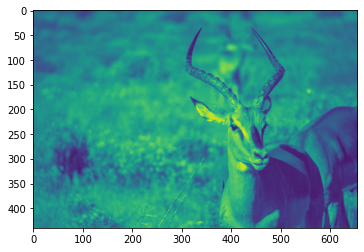

In [ ]:
#Etapa de descompressão: Junção das sub-imagens

#Realizar a operação em todas as matrizes dos canais Y, Cr e Cb
#A junção ocorre tendo como parâmetro as dimensões das imagens anterior ao processo de separação em blocos, para que a imagem retorne ao tamanho original
Y = join(Y_ITrans, im_Sub[0])
Cr_Jun = join(Cr_ITrans, im_Sub[1])
Cb_Jun = join(Cb_ITrans, im_Sub[2])

#Exemplo: exibir matriz resultante do canal de luminância após operação de junção
#Nesse momento, o canal Y já se encontra em seu estado final
print("Imagem final do canal Y:")
plt.imshow(Y)

Imagem final do canal Cr:


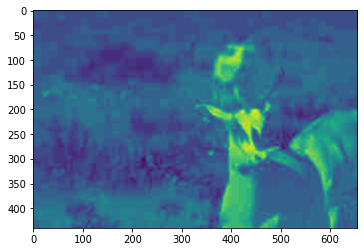

In [ ]:
#Etapa de descompressão: Super-amostragem dos canais Cr e Cb

#Operação de super-amostragem nos canais de crominância
#Nesse caso, a super-amostragem terá como parâmetro o resultado final do canal Y, pois desejamos que os canais Cr e Cb retornem ao seu tamanho original
#Como Y já está em seu tamanho original, Cr e Cb assumirão as dimensões de Y
Cr, Cb = superSample(Cr_Jun, Cb_Jun, Y)

#Exemplo: exibir matriz resultante do canal Cr após operação de super-amostragem
#Nesse momento, todos os canais já se encontram em seu estado final
print("Imagem final do canal Cr:")
plt.imshow(Cr)

Imagem final (YCrCb):


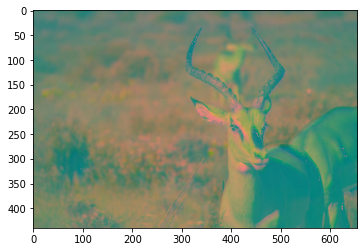

In [ ]:
#Etapa de descompressão: Junção dos canais Y, Cr e Cb

#Declaração da imagem resultante
YCrCb_Final = np.empty((Y.shape[0], Y.shape[1], 3), 'uint8')

#Preenchimento do vetor com as matrizes finais obtidas após os processos
YCrCb_Final[..., 0] = Y
YCrCb_Final[..., 1] = Cr
YCrCb_Final[..., 2] = Cb

#Exibir imagem resultante no espaço YCrCb
print("Imagem final (YCrCb):")
plt.imshow(YCrCb_Final)

Imagem final:


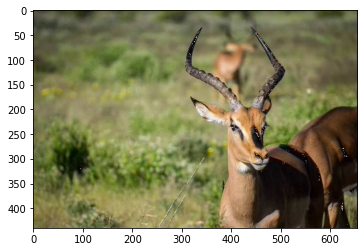

In [ ]:
#Etapa de descompressão: Transformação do espaço YCrCb para RGB

#Finalmente, temos a imagem resultante de todos os processos
im_Final = cv2.cvtColor(YCrCb_Final, cv2.COLOR_YCR_CB2RGB)

#Exibir imagem final
print("Imagem final:")
plt.imshow(im_Final)

Imagem inicial:


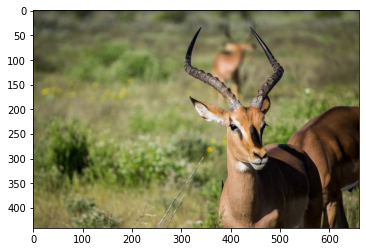

In [ ]:
#Somente para efeitos de comparação, será exibida a imagem original
print("Imagem inicial:")
plt.imshow(im_Inicial)

In [ ]:
#Cálculo das métricas Mean Square Error (MSE), Signal Noise Ratio (SNR) e Peak Signal Noise Ratio (PSNR) entre as imagens inicial e final

print("Mean Square Error (MSE):", mse(im_Inicial[0 : Y.shape[0], 0 : Y.shape[1]], im_Final))
print("Signal Noise Ratio (SNR):", snr(im_Inicial[0 : Y.shape[0], 0 : Y.shape[1]], im_Final))
print("Peak Signal Noise Ratio (PSNR):", psnr(im_Inicial[0 : Y.shape[0], 0 : Y.shape[1]], im_Final))

Mean Square Error (MSE): 212.30374861419068
Signal Noise Ratio (SNR): 49.280181181255614
Peak Signal Noise Ratio (PSNR): 24.861226983642524


Notamos que a imagem resultante é semelhante a original, porém não idêntica devido aos processos com perda. Ainda assim, visualmente, observamos que as perdas do processo não foram intensas. É possível notar uma pequena perda de qualidade da imagem. Por exemplo, alguns pontos dos corpos dos animais estão com ruído (pontos brancos e pretos ao invés da cor original).